<a href="https://colab.research.google.com/github/CarlosSotero/DeepLearning_CatvsDog/blob/main/Pr%C3%A1tica_com_Deep_Learning_para_Classifica%C3%A7%C3%A3o_de_Imagens_(vers%C3%A3o_melhorada).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

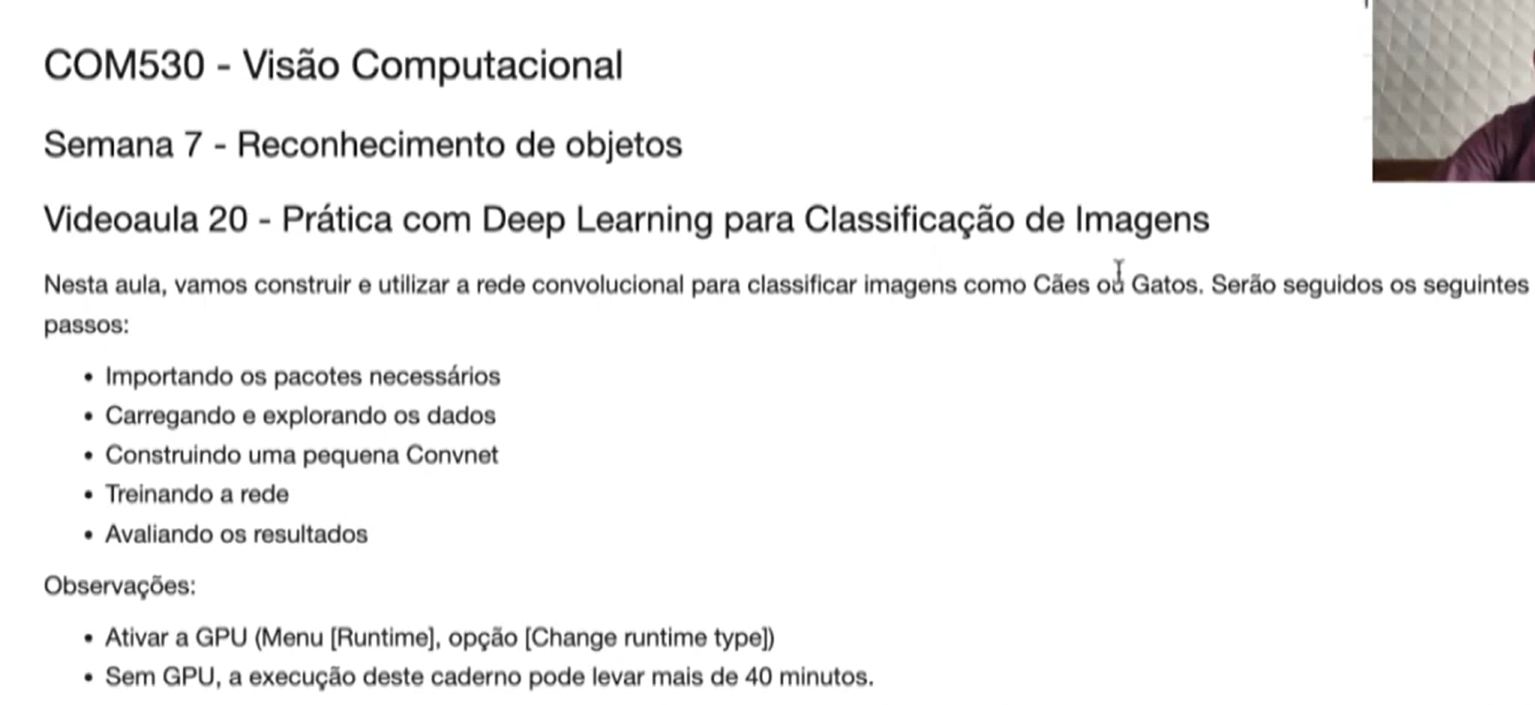

##**Importando os pacotes**

In [1]:

import os                  # Biblioteca nativa para manipulação de diretórios e caminhos
import zipfile             # Para extrair arquivos .zip quando necessário

# Comando do Jupyter Notebook para exibir gráficos diretamente na célula
%matplotlib inline

import matplotlib.pyplot as plt      # Biblioteca principal para gerar gráficos e visualizações
import matplotlib.image as mpimg     # Para carregar e exibir imagens com matplotlib

# Importações do TensorFlow / Keras para construir redes neurais
import tensorflow as tf
from tensorflow.keras import layers                          # Camadas usadas para criar a CNN
from tensorflow.keras import Model                           # Classe base para modelos
from tensorflow.keras.optimizers import RMSprop              # Otimizador RMSprop (bom para CNNs)
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,                                       # Para aumentar o dataset (data augmentation)
    img_to_array,                                             # Converte imagens em arrays NumPy
    load_img                                                  # Carrega imagens individuais
)

import numpy as np         # Biblioteca numérica essencial para trabalhar com arrays e tensores
import random              # Para operações aleatórias, como embaralhar dados
import shutil

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Caminho dos modelos salvos
MODEL_PATH = "/content/drive/MyDrive/models/cat_vs_dog_mobilenetv2.h5"

##**Carregando os dados**

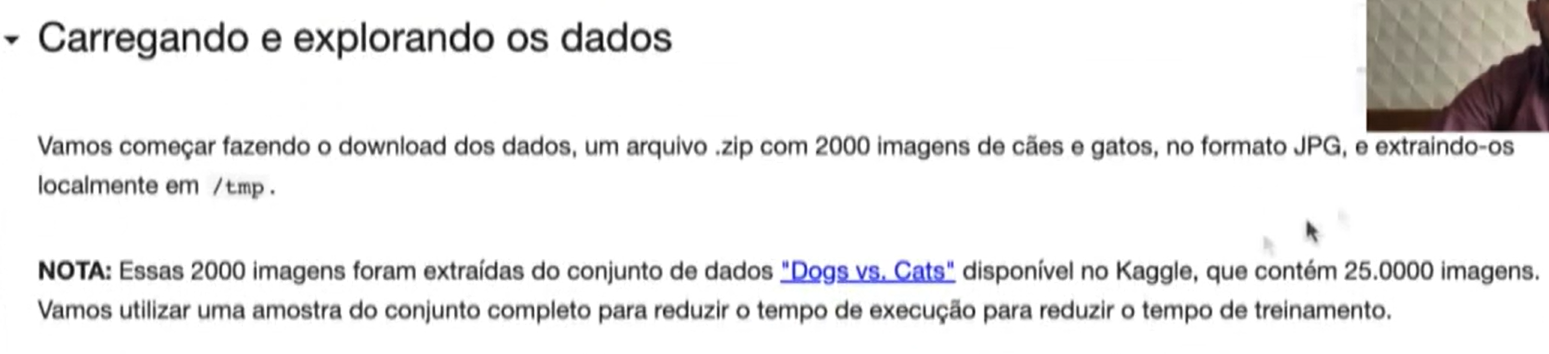

In [3]:
# Link do download do dataset
!wget --no-check-certificate https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip


# Nome do arquivo ZIP que contém o dataset.
local_zip = 'kagglecatsanddogs_5340.zip'

# Diretório onde o conteúdo do ZIP será extraído.
base_dir = '/content/Cats_vs_Dogs'

# Abre o arquivo ZIP no modo de leitura.
# zipfile.ZipFile permite manipular arquivos compactados.
zip_ref = zipfile.ZipFile(local_zip, 'r')

# Extrai todo o conteúdo do arquivo ZIP para o diretório base_dir.
# Caso a pasta não exista, o zipfile normalmente cria durante a extração.
zip_ref.extractall(base_dir)

# Fecha o arquivo ZIP após a extração para liberar recursos.
zip_ref.close()

--2026-01-30 17:24:31--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.61.186.113, 2600:1408:ec00:887::317f, 2600:1408:ec00:89b::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.61.186.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M  45.8MB/s    in 12s     

2026-01-30 17:24:44 (65.0 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [4]:
# Diretório original contendo as imagens do dataset.
# No caso do Cats vs Dogs, dentro desta pasta existem:
#   /PetImages/Cat
#   /PetImages/Dog
original_dir = '/content/Cats_vs_Dogs/PetImages'

# Diretório base onde você vai organizar o novo dataset
# em pastas separadas para treino e validação.
base_dir = '/content/dataset'

# Caminho das pastas de treino e validação.
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')

# Cria as pastas 'train' e 'val' (se já existirem, não gera erro).
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Para cada classe (cat e dog):
# cria subpastas específicas dentro de 'train' e 'val'.
# Estrutura final:
#   /content/dataset/train/cat
#   /content/dataset/train/dog
#   /content/dataset/val/cat
#   /content/dataset/val/dog
for cls in ['cat', 'dog']:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

In [5]:
from PIL import Image

def remove_imagens_corrompidas(diretorio):
    imagens_removidas = 0
    for root, _, files in os.walk(diretorio):
        for fname in files:
            path = os.path.join(root, fname)
            try:
                img = Image.open(path)
                img.verify()  # verifica se a imagem é válida
            except Exception:
                os.remove(path)
                imagens_removidas += 1
    print(f"Imagens corrompidas removidas de {diretorio}: {imagens_removidas}")


cats_dir = '/content/Cats_vs_Dogs/PetImages/Cat'
dogs_dir = '/content/Cats_vs_Dogs/PetImages/Dog'


In [6]:
remove_imagens_corrompidas(cats_dir)
remove_imagens_corrompidas(dogs_dir)

Imagens corrompidas removidas de /content/Cats_vs_Dogs/PetImages/Cat: 2


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Imagens corrompidas removidas de /content/Cats_vs_Dogs/PetImages/Dog: 2


In [7]:
def split_and_copy(class_name, split_ratio=0.8):
    """
    Separa as imagens de uma classe em treino e validação e copia para as pastas correspondentes.

    Parâmetros:
        class_name (str): nome da classe, por exemplo 'cat' ou 'dog'.
        split_ratio (float): proporção destinada ao conjunto de treino (ex.: 0.8 = 80% treino, 20% validação).

    Pré-requisitos (variáveis globais esperadas):
        - original_dir: diretório raiz onde estão as pastas originais (ex.: .../PetImages)
        - train_dir: diretório base do conjunto de treino (com subpastas por classe)
        - val_dir: diretório base do conjunto de validação (com subpastas por classe)
        - os, random, shutil já importados
    """
    # Monta o caminho da pasta de origem para a classe.
    # O dataset "PetImages" usa pastas com a primeira letra maiúscula: "Cat" e "Dog"
    src_dir = os.path.join(original_dir, class_name.capitalize())

    # Lista todos os arquivos presentes na pasta da classe.
    images = os.listdir(src_dir)

    # Filtra apenas arquivos .jpg para evitar arquivos corrompidos/formatos diferentes.
    # (Esse dataset possui alguns arquivos não-imagem e imagens com problemas.)
    images = [img for img in images if img.endswith('.jpg')]

    # Embaralha a lista para garantir aleatoriedade na divisão treino/validação.
    random.shuffle(images)

    # Define o ponto de corte com base na proporção desejada para treino.
    split_point = int(len(images) * split_ratio)

    # Fatias resultantes: primeiras N imagens para treino e o restante para validação.
    train_imgs = images[:split_point]
    val_imgs   = images[split_point:]

    # Copia as imagens de treino para a subpasta correspondente da classe.
    for img in train_imgs:
        shutil.copy(
            os.path.join(src_dir, img),                  # caminho completo do arquivo de origem
            os.path.join(train_dir, class_name, img)     # destino: .../train/<classe>/<arquivo>
        )

    # Copia as imagens de validação para a subpasta correspondente da classe.
    for img in val_imgs:
        shutil.copy(
            os.path.join(src_dir, img),                  # caminho completo do arquivo de origem
            os.path.join(val_dir, class_name, img)       # destino: .../val/<classe>/<arquivo>
        )

In [8]:
# Chama a função split_and_copy para a classe "cat".
# Isso vai:
# - localizar a pasta original "Cat"
# - separar em 80% treino e 20% validação (padrão do split_ratio)
# - copiar os arquivos para:
#     /content/dataset/train/cat
#     /content/dataset/val/cat
split_and_copy('cat')

# Mesma coisa acima, mas agora para a classe "dog":
# - pasta original "Dog"
# - embaralha, divide e copia para:
#     /content/dataset/train/dog
#     /content/dataset/val/dog
split_and_copy('dog')

In [9]:
print('Treino - Gatos:', len(os.listdir(os.path.join(train_dir, 'cat'))))
print('Treino - Cães :', len(os.listdir(os.path.join(train_dir, 'dog'))))
print('Val - Gatos   :', len(os.listdir(os.path.join(val_dir, 'cat'))))
print('Val - Cães    :', len(os.listdir(os.path.join(val_dir, 'dog'))))

Treino - Gatos: 9999
Treino - Cães : 9999
Val - Gatos   : 2500
Val - Cães    : 2500


In [10]:
# Monta o caminho para a pasta onde ficaram as imagens de treino da classe "cat".
# Esse caminho foi criado anteriormente na etapa de organização:
# /content/dataset/train/cat
train_cats_dir = os.path.join(train_dir, 'cat')

# Monta o caminho para a pasta das imagens de treino da classe "dog":
# /content/dataset/train/dog
train_dogs_dir = os.path.join(train_dir, 'dog')

# Lista todos os arquivos (nomes das imagens) dentro da pasta de treino dos gatos.
# Isso permite verificar quantas imagens foram copiadas e novamente usá-las se necessário.
train_cat_fnames = os.listdir(train_cats_dir)

# Lista os arquivos da pasta de treino dos cachorros.
train_dog_fnames = os.listdir(train_dogs_dir)

**Olhando as imagens**

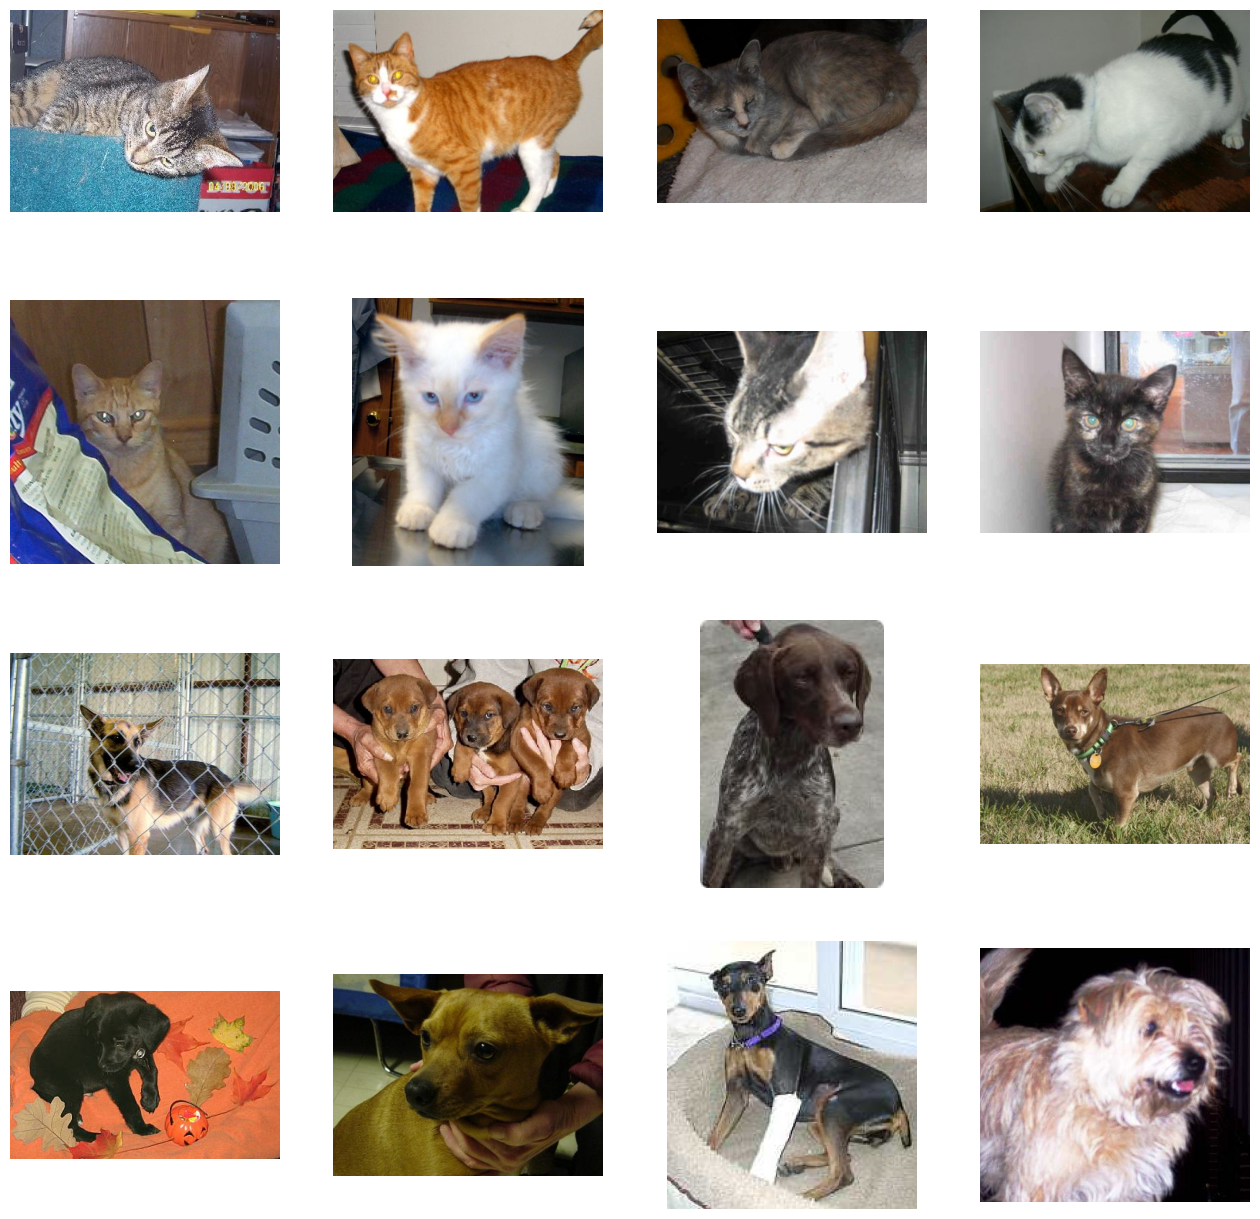

In [11]:
# Parâmetros para o gráfico (formato 4x4)
nrows = 4
ncols = 4

# Índice para iterar sobre as imagens
pic_index = 0

# Configurar o matplotlib fig, e dimensioná-lo
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

# Avança 8 imagens
pic_index += 8

# Seleciona imagens de treino
next_cat_pix = [
    os.path.join(train_cats_dir, fname)
    for fname in train_cat_fnames[pic_index-8:pic_index]
]

next_dog_pix = [
    os.path.join(train_dogs_dir, fname)
    for fname in train_dog_fnames[pic_index-8:pic_index]
]

# Plot
for i, img_path in enumerate(next_cat_pix + next_dog_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

##**Construindo a rede Convnet**

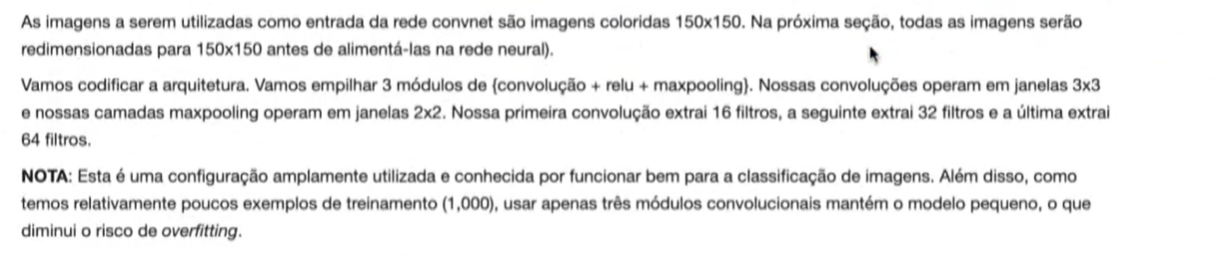

In [12]:
from tensorflow.keras.applications import MobileNetV2

# Define o tensor de entrada das imagens no formato (altura, largura, canais).
# Aqui: imagens RGB 150x150.
img_input = layers.Input(shape=(150, 150, 3))

# Backbone pré-treinado
# Carrega o MobileNetV2 com pesos do ImageNet, sem a "cabeça" densa final (include_top=False),
# e usa o tensor de entrada definido acima (input_tensor=img_input).
base_model = MobileNetV2(
    weights='imagenet',     # inicializa com pesos pré-treinados no ImageNet (transfer learning)
    include_top=False,      # remove as camadas densas originais do MobileNetV2
    input_tensor=img_input  # conecta a entrada do seu modelo ao backbone
)

# Congela o backbone
# Impede que os pesos do MobileNetV2 sejam atualizados durante o treinamento inicial,
# treinando apenas a "cabeça" que você definiu abaixo.
base_model.trainable = False

# Pega a saída do backbone e adiciona camadas para adaptar ao seu problema binário (cats vs dogs).
x = base_model.output

# GlobalAveragePooling2D substitui o flatten sobre mapas de ativação, reduzindo a dimensionalidade
# e ajudando a evitar overfitting (agrega espacialmente cada mapa de feature).
x = layers.GlobalAveragePooling2D()(x)

# Camada densa intermediária para aprender combinações não-lineares das features extraídas.
x = layers.Dense(128, activation='relu')(x)

# Dropout para regularização: desativa aleatoriamente 50% dos neurônios dessa camada durante o treino,
# reduzindo overfitting.
x = layers.Dropout(0.5)(x)

# Camada de saída com 1 neurônio e ativação sigmoide para classificação binária (0/1).
output = layers.Dense(1, activation='sigmoid')(x)

# Constrói o modelo final conectando a entrada definida ao início e a saída no final.
model = Model(inputs=img_input, outputs=output)



/tmp/ipython-input-924690993.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Sumerizando a arquitetura**

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 75, 75,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 75, 75,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 75, 75,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 75, 75,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 75, 75,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 75, 75,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 77, 77,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 38, 38,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 38, 38,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
model.compile(
    # Função de perda usada quando o problema é de classificação binária.
    # Ela mede a diferença entre a probabilidade prevista (sigmoid) e o rótulo real (0 ou 1).
    # É a loss mais comum para modelos com saída sigmoid.
    loss='binary_crossentropy',

    # Otimizador RMSprop:
    # - É muito eficiente em problemas com dados ruidosos, imagens e deep learning no geral.
    # - learning_rate=0.001 é um valor padrão e estável para a maioria dos casos.
    optimizer=RMSprop(learning_rate=1e-4),

    metrics=[
        # 'accuracy': porcentagem de acertos (previsões corretamente classificadas).
        'accuracy',

        # Métrica AUC (Area Under the ROC Curve):
        # - Mede a capacidade do modelo de separar as classes.
        # - AUC é mais robusta que accuracy quando o dataset é desbalanceado.
        # - name='auc' define o nome exibido no training log.
        tf.keras.metrics.AUC(name='auc')
    ]
)

##**Treinando a rede**

###**Pré-processamento dos dados**

In [15]:
# Imagens sendo normalizadas
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, # Permite rotacionar a imagem aleatoriamente até ±20 graus
    width_shift_range=0.1, # Desloca a imagem horizontalmente até 10% da largura.
    height_shift_range=0.1, # Mesmo conceito anterior, porém na vertical
    shear_range=0.1, # Distorção geométrica leve, como se a imagem fosse “esticada em diagonal”.
    zoom_range=0.1, # Zoom aleatório para dentro ou para fora ±10%.
    horizontal_flip=True # Espelha a imagem horizontalmente
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Fluxo de imagens de treinamento em lotes de 20 utilizando o gerador train_datagen
train_generator = train_datagen.flow_from_directory(
    train_dir, # As imagens
    target_size=(150,150), # Imagens serão redimensionadas para 150x150
    batch_size=20,
    class_mode='binary' # Como usamos binary_crossentropy, precisamos de rótulos binários
)

# Fluxo de imagens de validação em lotes de 20 usando o gerador
validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150), # Imagens serão redimensionadas para 150x150
    batch_size=20,
    class_mode='binary'
)

Found 19998 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


##**Treinamento**

In [16]:
# Treinamento do modelo utilizando um gerador de imagens (train_generator).
# fit_generator é usado quando os dados são carregados aos poucos via generator,
# especialmente útil para datasets grandes ou com data augmentation.

history = model.fit(
    train_generator,        # Gerador que fornece as imagens de treino em batches
    #steps_per_epoch = 100,  # Quantas batches o modelo deve procesar antes de "fechar" uma época.
                            # Ex.: se batch_size=20, você treina 100 * 20 = 2000 imagens por época.

    epochs = 15,            # Número total de épocas de treinamento.
                            # Cada época passa pelas 'steps_per_epoch' batches.

    validation_data = validation_generator,  # Gerador das imagens de validação.

    validation_steps = 50,  # Quantas batches de validação usar por época para avaliar o modelo.
                            # Ex.: se batch_size=20, isso avalia 50 * 20 = 1000 imagens por época.

    verbose = 1             # Nível de verbosidade:
                            # 0 = silencioso
                            # 1 = barra de progresso
                            # 2 = logs mais compactos (um por época)
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 588s 582ms/step - accuracy: 0.8819 - auc: 0.9493 - loss: 0.2670 - val_accuracy: 0.9630 - val_auc: 0.9963 - val_loss: 0.0790
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 551s 550ms/step - accuracy: 0.9432 - auc: 0.9883 - loss: 0.1385 - val_accuracy: 0.9690 - val_auc: 0.9951 - val_loss: 0.0894
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 553s 553ms/step - accuracy: 0.9463 - auc: 0.9900 - loss: 0.1282 - val_accuracy: 0.9610 - val_auc: 0.9938 - val_loss: 0.0926
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 543s 543ms/step - accuracy: 0.9531 - auc: 0.9910 - loss: 0.1189 - val_accuracy: 0.9720 - val_auc: 0.9950 - val_loss: 0.0819
Epoch 5/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 620s 620ms/step - accuracy: 0.9511 - auc: 0.9903 - loss: 0.1244 - val_accuracy: 0.9600 - val_auc: 0.9914 - val_loss: 0.1153
Epoch 6/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 541s 541ms/step - accuracy: 0.9528 - auc: 0.9909 - loss: 0.1192 - val_accuracy: 0.9630 - val_auc: 0.9956 - val_loss: 0.0885
Epoc

In [17]:
# Salvando o modelo
save_model_dir = '/content/Cats_vs_Dogs/saved_models'
os.makedirs(save_model_dir, exist_ok=True)

model.save(os.path.join(save_model_dir, 'cat_vs_dog_v2.hdf5'))


In [18]:
# Carregar o modelo previamente gravado
# from tensorflow.keras.models import load_model

# model = load_model(MODEL_PATH, compile=False)

##**Avaliando Resultados**

<Figure size 640x480 with 0 Axes>

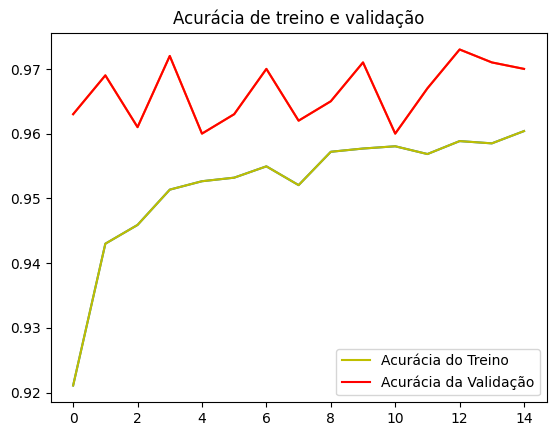

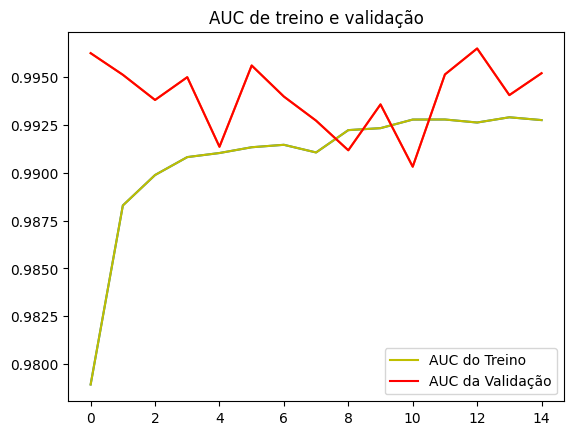

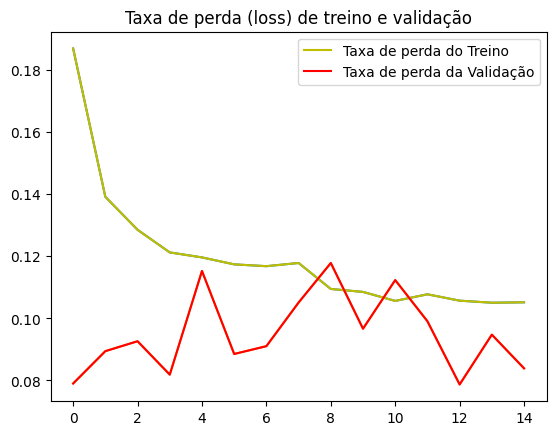

<Figure size 640x480 with 0 Axes>

In [19]:
# Recupera uma lista de resultados de acurácia nos conjuntos de dados de treinamento e validação
# para cada época do treinamento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Recupera uma lista de resultados de perda (loss) nos conjuntos de dados de
# treinamento e validação para cada época do treinamento
loss = history.history['loss']
val_loss = history.history['val_loss']

auc = history.history['auc']
val_auc = history.history['val_auc']

# Número de épocas
epochs = range(len(acc))

# Plota a acurácia de treino e validação em cada época
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.plot(epochs, acc, 'y-', label='Acurácia do Treino')
plt.plot(epochs, val_acc, 'r-', label='Acurácia da Validação')
plt.title('Acurácia de treino e validação')
plt.legend()
plt.figure()

# Plota o AUC de treino e validação em cada época
plt.plot(epochs, auc)
plt.plot(epochs, val_auc)
plt.plot(epochs, auc, 'y-', label='AUC do Treino')
plt.plot(epochs, val_auc, 'r-', label='AUC da Validação')
plt.title('AUC de treino e validação')
plt.legend()
plt.figure()

# Plota a perda (loss) de treino e validação em cada época
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.plot(epochs, loss, 'y-', label='Taxa de perda do Treino')
plt.plot(epochs, val_loss, 'r-', label='Taxa de perda da Validação')
plt.legend()
plt.title('Taxa de perda (loss) de treino e validação')
plt.figure()
